In [1]:
# Run this cell to import everything we'll need.
from importlib import reload
import numpy as np
import tensorflow as tf
%matplotlib inline
from matplotlib import pyplot as plt
import unittest

# Custom code for this assignment
import graph; reload(graph)
import graph_test; reload(graph_test)

/home/yeunghoman/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


<module 'graph_test' from '/home/yeunghoman/w266/assignment/a1/tensorflow/graph_test.py'>

**Note:** If you get an error like

```
.../importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
```

You can safely ignore it - everything should still work fine.

# Fun with TensorFlow

The goal of this section is to familiarize yourself with the Python [TensorFlow API](https://www.tensorflow.org/api_docs/python/index.html). We'll be using TensorFlow throughout the class to implement deep learning models, which are the state-of-the-art on many NLP tasks such as machine translation, sentiment analysis, and language modeling.

### TensorFlow: Declarative Numerical Programming

The TensorFlow programming model has two phases:
1.  **Construct a graph** by running Python code
2.  **Execute the graph** by calling `session.run()`

In the **graph construction** phase, we operate on everything symbolically. Executing the Python code doesn't actually do any numerical calculations - it just tells TensorFlow how to do the computation later. Every variable you define here is a **Tensor**, which creates a node in the computation graph.

In the **execution phase**, we give TensorFlow input data and a list of output operations. It runs the data through the graph and returns numerical results as NumPy arrays.

#### Tensor Objects

Tensor objects are the symbolic equivalent of NumPy arrays, and support many similar operations. For example, to compute a linear model $y = vW + b$ in NumPy, you might do:
```python
# w, v are np.ndarray
y = np.dot(v, w) + b
```
In TensorFlow, this would be expressed as:
```python
# w, v, b are tf.Tensor
y = tf.matmul(v, w) + b
```

There are a few ways to define Tensors, but the most important are:

- **[Constants and sequences](https://www.tensorflow.org/versions/r0.10/api_docs/python/constant_op.html#constants-sequences-and-random-values)**, like tf.constant(), tf.zeros(), or tf.linspace(). These create a Tensor with a fixed value, and pretty much work like their NumPy equivalents.

- **[Variables](https://www.tensorflow.org/versions/r0.10/how_tos/variables/index.html)**, which are persistent and can be modified during execution. Think model parameters, which get updated by training.

- **[Placeholders](https://www.tensorflow.org/versions/r0.10/api_docs/python/io_ops.html#placeholder)**, which are used for data inputs. You feed these in by passing a NumPy array at execution time.

Operations on tensors - like `tf.matmul()` or `tf.nn.softmax()` - produce other tensors and add additional nodes to the graph.

#### Delayed Execution

The key difference between the NumPy code `y = np.dot(v, w) + b` and the TensorFlow equivalent `y = tf.matmul(v, w) + b` is that when the latter runs, it _doesn't actually do the computation_. Instead, it tells TensorFlow that `y` is derived by performing the `matmul` operation on `v` and `w`, followed by adding `b`. We refer to this as "building the graph." In order to crunch the numbers, you need to run the graph, such as:
```python
# w, b defined as persistent tf.Variable, assume w is 10-dimensional vector
y = tf.matmul(v, w) + b  # Add Op (Tensor) to the graph
y_value = session.run(y, feed_dict={v=np.ones(10)})  # Run the graph
```
where `feed_dict` is how we "feed" input (NumPy arrays) to TensorFlow, and `y_value` will be a NumPy array containing the result of the computation.

This seems clunky for such a simple example - but it will dramatically simplify things when we start working with more complicated models.

## Simple Adder

Below is the code to construct a simple adder in NumPy.

In [2]:
x = 5.0
y = 7.0
np.add(x, y)

12.0

As noted about delayed execution, the equivalent TensorFlow consists of two parts:
1.  Construct a computational graph.
2.  Execute it.

The graph will look something like this:
<img src="addgraph.png" alt="Graph" style="width: 200px;"/>


In [3]:
# Construct the computational graph.
tf.reset_default_graph()
x = tf.placeholder(tf.float32)
y = tf.placeholder(tf.float32)
z = tf.add(x, y)

# Execute it.
sess = tf.Session()
print(sess.run([z], feed_dict={x: 5.0, y: 7.0}))

# Note, you can re-execute the same computational graph with different inputs:
print(sess.run([z], feed_dict={x: 1.0, y: 2.0}))

[12.0]
[3.0]


The python API adds "syntactic sugar" whenever you do "normal" python binary operations on tensors.

In [4]:
# Construct the computational graph.
tf.reset_default_graph()
x = tf.placeholder(tf.float32)
y = tf.placeholder(tf.float32)
z = x + y  # Syntactic sugar for tf.add(x, y)

# Execute it.
sess = tf.Session()
print(sess.run([z], feed_dict={x: 5.0, y: 7.0}))

[12.0]


You can construct more complex graphs, and selectively execute them.  For example, here's a graph that contains both addition and subtraction.

<img src="addsubgraph.png" alt="Addition and Subtraction in one graph" style="width: 200px;"/>


In [5]:
# Construct the computational graph.
tf.reset_default_graph()
x = tf.placeholder(tf.float32)
y = tf.placeholder(tf.float32)
z_add = tf.add(x, y)
z_sub = tf.subtract(x, y)

# Execute it.
sess = tf.Session()
feed_dict = {x: 5.0, y: 7.0}
print("Adding: ", sess.run([z_add], feed_dict=feed_dict))
print("Subtracting: ", sess.run([z_sub], feed_dict=feed_dict))
print("Both: ", sess.run([z_add, z_sub], feed_dict=feed_dict))

Adding:  [12.0]
Subtracting:  [-2.0]
Both:  [12.0, -2.0]


## A. Coding Exercise

In the cell below, construct a computational graph that accepts three inputs and computes both:
1. `x1 * x2`
2. `(x1 * x2) + x3`

Use as few nodes in the graph as possible (i.e. use the fact the 1 is a sub-graph of 2).

_Hint:_ Use the "Both" approach from the previous cell.  For performance reasons, when called this way (multiple outputs at once), TensorFlow is "smart" enough to compute `x1 * x2` only once and use it in both 1 and 2.

Evaluate them for each of the following:

* `{x1: 2.0, x2: 3.0, x3: 4.0}`
* `{x1: 5.0, x2: 3.0, x3: 4.0}`
* `{x1: 6.0, x2: 3.0, x3: 4.0}`


In [11]:
#### YOUR CODE HERE ####
# Construct the computational graph.
tf.reset_default_graph()

x1 = tf.placeholder(tf.float32)
x2 = tf.placeholder(tf.float32)
x3 = tf.placeholder(tf.float32)

y_1 = tf.multiply(x1,x2) # + 1 node
y_2 = tf.add(y_1, x3) # + 1 node

# if y_2 = tf.add( tf.multiply(x1,x2), x3) # + 2 nodes

# Execute it.
sess=tf.Session()
print (sess.run([y_1,y_2], feed_dict={x1:2.0, x2:3.0, x3:4.0}))
print (sess.run([y_1,y_2], feed_dict={x1:5.0, x2:3.0, x3:4.0}))
print (sess.run([y_1,y_2], feed_dict={x1:6.0, x2:3.0, x3:4.0}))
#### END(YOUR CODE) ####

[6.0, 10.0]
[15.0, 19.0]
[18.0, 22.0]


If you did the exercise correctly, you should see:
```
[6.0, 10.0]
[15.0, 19.0]
[18.0, 22.0]
```
TensorFlow can perform operations on more than just scalars - we'll commonly use it to manipulate vectors, matricies,  vectors, matrices, and occasionally higher-order tensors.

In [12]:
# Construct the computational graph.
tf.reset_default_graph()
x = tf.placeholder(tf.float32)
y = tf.placeholder(tf.float32)
z_add = tf.add(x, y)

# Execute it.
sess = tf.Session()
print(sess.run([z_add], feed_dict={x: [5.0, 4.0], y: [7.0, 1.0]}))

[array([ 12.,   5.], dtype=float32)]


We can pass TensorFlow matrices from NumPy.

In [14]:
# Construct the computational graph.
tf.reset_default_graph()
x = tf.placeholder(tf.float32)
y = tf.placeholder(tf.float32)
z_add = tf.add(x, y)

# Execute it.
sess = tf.Session()
print(sess.run([z_add], feed_dict={x: np.ones([3, 3]), 
                                   y: 3*np.ones([3, 3])}))

[array([[ 4.,  4.,  4.],
       [ 4.,  4.,  4.],
       [ 4.,  4.,  4.]], dtype=float32)]


You can construct parts of graphs inside functions and return references to various operations in the graph.  This is a convenient way to construct the same subgraph in multiple places.

In [16]:
# Construct the computational graph.
tf.reset_default_graph()
def DoComplexComputation(a, b):
    """This function adds operations to the current TensorFlow graph.
    
    Args:
      a: Tensor (scalar)
      b: Tensor (scalar)
      
    Returns:
      Tensor (scalar)
    """
    return tf.add(tf.multiply(a, a), b) + tf.constant(3.6)

x = tf.placeholder(tf.float32) # + 1 node
y = tf.placeholder(tf.float32) # + 1 node

z_one_application = DoComplexComputation(x, y) # + 3 nodes?
z_two_applications = DoComplexComputation(z_one_application, y) # + another 3 nodes?

# Execute it.
sess = tf.Session()
print(sess.run([z_one_application, z_two_applications], feed_dict={x: 7.0, y: 9.0}))

# z_one_application = (x*x + y) + 3.6 = 61.6
# z_two_application = (61.6*61.6 + 9) + 3.6 = 3807.160

[61.599998, 3807.1599]


TensorFlow will broadcast shapes, similar to NumPy.  As you can see below, it does this silently and with no explicit opt-in from the user. If you're not careful, this can lead to subtle bugs!

For more information on how broadcasting works, see [NumPy broadcasting](https://docs.scipy.org/doc/numpy-1.13.0/user/basics.broadcasting.html) and [Broadcasting: the good and the ugly](https://github.com/vahidk/EffectiveTensorflow#broadcasting-the-good-and-the-ugly).

In [17]:
# Construct the computational graph.
tf.reset_default_graph()
x = tf.placeholder(tf.float32)
y = tf.placeholder(tf.float32)
z_add = tf.add(x, y)

# Execute it.
sess = tf.Session()
print(sess.run([z_add], feed_dict={x: [7.0, 3.0, 4.0], y: 2.0}))

[array([ 9.,  5.,  6.], dtype=float32)]


**In this course, you'll realize that one of the most important debugging techniques is to draw pictures of all your tensors on a scrap piece of paper and make sure that it matches you code.**

# Machine Learning in TensorFlow

### Brief Review of Machine Learning

In supervised learning, parametric models are those where the model is a function of a fixed form with a number of unknown _parameters_.  Together with a loss function and a training set, an optimizer can select parameters to minimize the loss with respect to the training set.  Common optimizers include stochastic gradient descent.  It tweaks the parameters slightly to move the loss "downhill" due to a small batch of examples from the training set.

### Linear & Logistic Regression

You've likely seen linear regression before.  In linear regression, we fit a line (technically, hyperplane) that predicts a target variable, $y$, based on some features $x$.  The form of this model is affine (even if we call it "linear"):  

$$y_{hat} = xW + b$$

where $W$ and $b$ are weights and an offset, respectively, and are the parameters of this parametric model.  The loss function that the optimizer uses to fit these parameters is the squared error ($||\cdots||_2$) between the prediction and the ground truth in the training set.

You've also likely seen logistic regression, which is tightly related to linear regression.  Logistic regression also fits a line - this time separating the positive and negative examples of a binary classifier.  The form of this model is similar: 

$$y_{hat} = \sigma(xW + b)$$

where again $W$ and $b$ are the parameters of this model, and $\sigma$ is the [sigmoid function](https://en.wikipedia.org/wiki/Sigmoid_function) which maps un-normalized scores ("logits") to values $\hat{y} \in [0,1]$ that represent probabilities. The loss function that the optimizer uses to fit these parameters is the [cross entropy](../information_theory.ipynb) between the prediction and the ground truth in the training set.

This pattern of an affine transform, $xW + b$, occurs over and over in machine learning.

**We'll use logistic regression as our running example for the rest of this assignment.**

## B.  Short Answer Questions

Imagine you want to implement logistic regression:

* `z = xW + b`
* `y_hat = sigmoid(z)`

Where:
1.  `x` is a 10-dimensional feature vector
2.  `W` is the weight vector
3.  `b` is the bias term

What are the dimensions of `W` and `b`?  Recall that in logistic regression, `z` is just a scalar (commonly referred to as the "logit").

Draw a picture of the whole equation using rectangles to illustrate the dimensions of `x`, `W`, and `b`.  See examples below for inspiration (though please label each dimension).  It's fine to do this part on paper and take a photo.

## B. Your Answers

1. W is a 10 by 1 vector.
2. b is a scalar.

![b_answer.png](b_answer.png)

## Batching

Let's say we want to perform inference using your model (parameters `W` and `b`) above on 10 examples intsead of just 1. On modern hardware (especially GPUs), we can do this efficiently by *batching*.

To do this, we stack up the feature vectors in x like in the diagram below.  Note that changing the number of examples you run on (i.e. your batch size) *does not* affect the number of parameters in your model.  You're just running the same thing in parallel (instead of running the above one feature vector at a time at a time).

![](batchaffine.png)

The red (# features) and blue (batch size) lines represent dimensions that are the same.

## C.  Short Answer Questions

If we have 10 features and running the model in parallel with 20 examples, what are the dimensions of:

1. `W` ?
2. `b` ?
3. `x` ?
4. `z` ?

_Hint:_ remember that your model parameters stay fixed!

## C. Your Answers

1.  10 by 1 vector -- fixed
2.  scalar -- fixed
3.  20 by 10 feature matrix
4.  20 by 1 vector

## D.  Short Answer Questions

Recall `y_hat = sigmoid(z)`.

If you were to run your model one example of the time and `z = 0.8` for the first example and `z = -0.3` for the second example, that would result in `y_hat = 0.689` and `y_hat = 0.426`, respectively.

If you run them in parallel/as a batch, the answers shouldn't change.

Answer these questions:

1.  What is the shape of `y_hat` when running in a batch, in terms of other dimensions.
2.  What is the value of `y_hat` (as a vector) when running on the batch described earlier in this question?
3.  Why do you think `sigmoid(vector)` is sometimes referred to as "the sigmoid is applied element-wise"?

## D.  Your answers

1. Vectical dimension v is same as batch size (typically number of examples), horizontal dimension h is 1 (1 scalar output per example). We can also think of it as having the same dimension as the logit matrix z (which stacks z1 and z2 in this case) that is 2 by 1 in this case.
2. [0.689, 0.426]
3. The sigmoid function is applied to each scalar element in the vector, this produces a resultant vector of the same shape but sigmoid transformed values. The elements in the input vector does not interact with each other due to the sigmoid function.

## E.  Short Answer Questions

In deep neural networks, there are often intermediate "hidden layers", a vector per example.

Building on the batching in the previous example, the formulation looks like this:

![](batchdnnaffine.png)

Assuming we want a hidden layer size of 75 (continuing with 10 features and a batch size of 20 examples), what are the shapes of:
1. W?
2. b?
3. x?
4. z?

## E. Your Answers

1.  10 by 75 -- 10 features by hidden layer size 75.
2.  vector of size 75. b will be broadcasted rowise to the result to XW which is 20 by 75.
3.  20 by 10 -- remains unchanged. 20 examples and 10 features each.
4.  20 by 75 -- corresponding to 20 examples input, each transformed from having 10 attributes to 75 attributes.

## Putting it all together

In all of these cases, the optimizer needs:

- A batch of examples of $x$ and $y$ from the training set
- Variables to maintain the current values of the parameters of the model
- A loss function _(such as cross-entropy)_
- An optimization strategy _(such as stochastic gradient descent (SGD))_

## F. Coding exercise

In this section, you don't need to create the graph and session (we've done it for you).  Instead, you will simply implement functions (in `graph.py`) that construct parts of a larger graph.

You will first build an affine layer: 

$$z = xW + b$$

and then then a stack of fully connected layers (described in more detail below), each implementing 

$$h^{(i)} = f(h^{(i-1)}W + b)$$

You'll use the former as a building block for the latter.

### F.1 Affine Layer
In particular, your function will accept a TensorFlow Op that represents the value of $x$ and should return value $z$ of desired dimension.  You must construct whatever variables you need.

**In `graph.py`, implement `affine_layer(...)` **

**Remember to take a photo** of the sketch we ask you to make in the function's comments.
![Name your image f1_answer.png and rerun this cell](f1_answer.png)

Hints:
- use `tf.get_variable()` to create variables to store the current values of parameters.
- `W` should be randomly initialized using [Xavier initialization](https://www.tensorflow.org/versions/master/api_docs/python/contrib.layers/initializers)
- `b` should be initialized to a vector of zeros
- `a * b` is a element-wise product, but what you'll want here is proper matrix multiplication (`tf.matmul`).

Run the little fragment below until you get your code up and running, then run the more comprehensive unit tests in the cell below that.

In [3]:
reload(graph)
with tf.Graph().as_default():
    tf.set_random_seed(0)
    sess = tf.Session()
    x_ph = tf.placeholder(tf.float32, shape=(None, 3))
    y = graph.affine_layer(1, x_ph)  #### <---- Your code called here.
    sess.run(tf.global_variables_initializer())
    
    print('You should have two trainable variables, one for each of parameters W and b: ', 
          len(tf.trainable_variables()))
    assert len(tf.trainable_variables()) == 2

    print('These should be a (3, 1) W weight matrix and a (1,) offset.')
    variables = sess.run(tf.trainable_variables())
    print(variables[0].shape)
    print(variables[1].shape)
    assert set([variables[0].shape, variables[1].shape]) == set([(3, 1), (1,)])

    print('This should be [[-2.36877394]].')
    y_val = sess.run(y, feed_dict={x_ph: np.array([[1, 2, 3]])})
    print(y_val)
    assert y_val.shape == (1, 1)

You should have two trainable variables, one for each of parameters W and b:  2
These should be a (3, 1) W weight matrix and a (1,) offset.
(3, 1)
(1,)
This should be [[-2.36877394]].
[[-2.36877394]]


In [4]:
reload(graph)
reload(graph_test)
unittest.TextTestRunner(verbosity=2).run(
    unittest.TestLoader().loadTestsFromName(
        'TestLayer.test_affine', graph_test))

test_affine (graph_test.TestLayer) ... ok

----------------------------------------------------------------------
Ran 1 test in 0.025s

OK


<unittest.runner.TextTestResult run=1 errors=0 failures=0>

### F.2: Fully-Connected Layers

A fully connected layer has the following form (you'll notice this is very similar to logistic regression!):

1.  An affine transform $z^{(i)} = h^{(i-1)}W_i + b_i$
2.  An elementwise nonlinearity $h^{(i)} = f(z^{(i)})$

Logistic regression can be thought of as a single fully-connected layer where $f = \sigma$ is a sigmoid. We'll use [ReLU](https://en.wikipedia.org/wiki/Rectifier_(neural_networks) here instead, but the structure is otherwise the same.

These fully connected layers can be stacked repeatedly to build a deep neural network:

$$ \begin{eqnarray} 
h^{(0)} & = &\ x \\
h^{(1)} & = &\ f(z^{(1)})\ =\ f(h^{(0)}W_1 + b_1) \\
h^{(2)} & = &\ f(z^{(2)})\ =\ f(h^{(1)}W_2 + b_2) \\
&\ldots& \\
h^{(i)} & = &\ f(z^{(i)})\ =\ f(h^{(i-1)}W_i + b_i) \\
\end{eqnarray}$$

**In `graph.py`, implement the `fully_connected_layers()` function.**

In [5]:
reload(graph)
reload(graph_test)
unittest.TextTestRunner(verbosity=2).run(
    unittest.TestLoader().loadTestsFromName(
        'TestLayer.test_fully_connected_layers', graph_test))


test_fully_connected_layers (graph_test.TestLayer) ... ok

----------------------------------------------------------------------
Ran 1 test in 0.119s

OK


<unittest.runner.TextTestResult run=1 errors=0 failures=0>

In [6]:
reload(graph)
reload(graph_test)
unittest.TextTestRunner(verbosity=2).run(
    unittest.TestLoader().loadTestsFromName(
        'TestLayer.test_no_fully_connected_layers', graph_test))

test_no_fully_connected_layers (graph_test.TestLayer) ... ok

----------------------------------------------------------------------
Ran 1 test in 0.006s

OK


<unittest.runner.TextTestResult run=1 errors=0 failures=0>

### F.3 Compute logits

Use the functions you've already implemented to build the computational graph taking features `x_ph` through a forward pass of a fully connected neural network with dimensions `hidden_dims` (a list of integers, like `[50, 35, 10]`).

**In `graph.py`, implement `MakeLogits()`**

In [7]:
reload(graph)
reload(graph_test)
unittest.TextTestRunner(verbosity=2).run(
    unittest.TestLoader().loadTestsFromName(
        'TestLayer.test_make_logits', graph_test))

test_make_logits (graph_test.TestLayer) ... ok

----------------------------------------------------------------------
Ran 1 test in 0.062s

OK


<unittest.runner.TextTestResult run=1 errors=0 failures=0>

### F.4 Compute loss
Given the logits and the labels, compute cross entropy loss.

**In `graph.py`, implement `MakeLoss()`**

In [8]:
reload(graph)
reload(graph_test)
unittest.TextTestRunner(verbosity=2).run(
    unittest.TestLoader().loadTestsFromName(
        'TestLayer.test_make_loss', graph_test))

test_make_loss (graph_test.TestLayer) ... ok

----------------------------------------------------------------------
Ran 1 test in 0.311s

OK


<unittest.runner.TextTestResult run=1 errors=0 failures=0>

### F.5 Training a Neural Network

Let's put it all together, and build a simple neural network that fits some training data.

**Read the code for `train_nn()`, in `graph.py`**

Note that much of this is boilerplate, but all the elements should be familiar from above: constructing the graph, feeding minibatches from NumPy arrays, and calling `session.run()`. On future assignments, we'll make use of the high-level [`tf.Estimator`](https://www.tensorflow.org/programmers_guide/estimators) API to abstract away some of this and allow us to focus on the model structure.

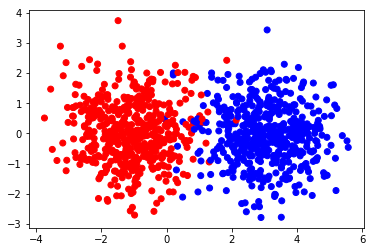

In [11]:
reload(graph_test)
X_train, y_train, X_test, y_test = graph_test.generate_data(1000, 10)
plt.scatter(X_train[:,0], X_train[:,1], c=y_train, cmap='bwr');

**Hint:** You should expect to see an initial loss here of 0.2 - 1.0.  This is because a well-initialized random classifier tends to output a uniform distribution.  For each example in the batch, we either compute the cross-entropy loss of the label (`[1, 0]` or `[0, 1]`) against the model's output (`~[0.5, 0.5]`).  Both cases result in $-\ln(0.5) = ln(2) = 0.69$.

Of course, your random classifier won't output exactly uniform distributions (it's random after all), but you should anticipate it being pretty close.  If it's not, your initialization may be broken and make it hard for your network to learn.

**[Optional]** Some technical details... if your randomly initialized network is outputting very confident predictions, the loss computed may be very large while at the same time the sigmoids in the network are likely in saturation, quickly shrinking gradients.  The result is that you make tiny updates in the face of a huge loss.

In [13]:
reload(graph)
reload(graph_test)
unittest.TextTestRunner(verbosity=2).run(
    unittest.TestLoader().loadTestsFromName(
        'TestNN.test_train_nn', graph_test))


test_train_nn (graph_test.TestNN) ... 

Initial loss: 0.224549
Step:  20 Loss: 0.198982


ok

----------------------------------------------------------------------
Ran 1 test in 0.117s

OK


<unittest.runner.TextTestResult run=1 errors=0 failures=0>

In [14]:
reload(graph)
reload(graph_test)
unittest.TextTestRunner(verbosity=2).run(
    unittest.TestLoader().loadTestsFromName(
        'TestNN.test_train_nn_with_fclayers', graph_test))

test_train_nn_with_fclayers (graph_test.TestNN) ... 

Initial loss: 0.742249
Step:  20 Loss: 0.731839


ok

----------------------------------------------------------------------
Ran 1 test in 0.246s

OK


<unittest.runner.TextTestResult run=1 errors=0 failures=0>

That was fairly straightforward...  the data is clearly linearly separable.

### Tuning Parameters

Let's try our network on a problem that's a bit harder! This is a version of the classic XOR problem, which is not linearly-separable. However, it's easy to solve with a deep network.

Here, we'll train a neural network with a couple of hidden layers before the final sigmoid.  This lets the network learn non-linear decision boundaries.

Try playing around with the hyperparameters to get a feel for what happens if you set the learning rate too big (or too small), or if you don't give the network enough capacity (i.e. hidden layers and width).

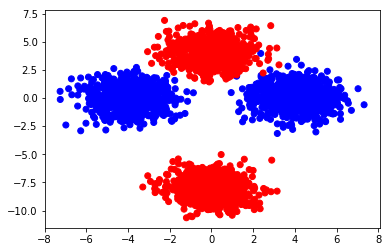

In [14]:
reload(graph_test)
X_train, y_train, X_test, y_test = graph_test.generate_non_linear_data(1000, 10)
plt.scatter(X_test[:,0], X_test[:,1], c=y_test, cmap='bwr')

In [22]:
hidden_layers = [10, 10]
batch_size = 50
epochs = 2000
learning_rate = 0.001
tf.reset_default_graph()
predictions = graph.train_nn(X_train, y_train, X_test, hidden_layers, batch_size, epochs, learning_rate)

Initial loss: 0.506506
Step:  20 Loss: 0.488202
Step:  6020 Loss: 0.0625876
Step:  12020 Loss: 0.0313436
Step:  18020 Loss: 0.023087
Step:  24020 Loss: 0.0193872
Step:  30020 Loss: 0.0173221
Step:  36020 Loss: 0.0160004


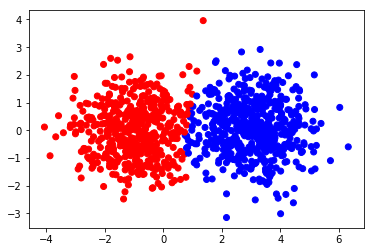

In [23]:
plt.scatter(X_test[:,0], X_test[:,1], c=predictions, cmap='bwr')

In [20]:
# learning rate too large
hidden_layers = [10, 10]
batch_size = 50
epochs = 2000
learning_rate = 5
tf.reset_default_graph()
predictions = graph.train_nn(X_train, y_train, X_test, hidden_layers, batch_size, epochs, learning_rate)

Initial loss: 0.733387
Step:  20 Loss: 0.205073
Step:  6020 Loss: 0.694454
Step:  12020 Loss: 0.694454
Step:  18020 Loss: 0.694454
Step:  24020 Loss: 0.694454
Step:  30020 Loss: 0.694454
Step:  36020 Loss: 0.694454


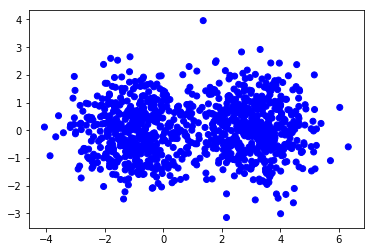

In [21]:
# learning rate too large
plt.scatter(X_test[:,0], X_test[:,1], c=predictions, cmap='bwr')

Note: With the same number of epochs, if our learning rate is too large, the algorithm over-steps the optimal solution and converge to a boundary that separates the data points well enough. This results in a very large error rate.

In [25]:
# learning rate too small
hidden_layers = [10, 10]
batch_size = 50
epochs = 2000
learning_rate = 0.0000001
tf.reset_default_graph()
predictions = graph.train_nn(X_train, y_train, X_test, hidden_layers, batch_size, epochs, learning_rate)

Initial loss: 0.804491
Step:  20 Loss: 0.788851
Step:  6020 Loss: 0.788324
Step:  12020 Loss: 0.787797
Step:  18020 Loss: 0.787273
Step:  24020 Loss: 0.786751
Step:  30020 Loss: 0.786235
Step:  36020 Loss: 0.785719


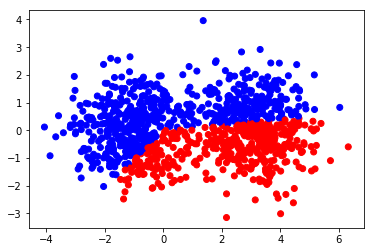

In [26]:
# learning rate too small
plt.scatter(X_test[:,0], X_test[:,1], c=predictions, cmap='bwr')

Note: With the same number of epochs, if our learning rate is too small, the algorithm makes steps that are too small and never make its way anywhere close enough to the optimal. This results in a very large error rate as well.

That looks pretty good!

Let's compare the predictions vs. the labels and see what we got wrong...

Accuracy: 97.16%


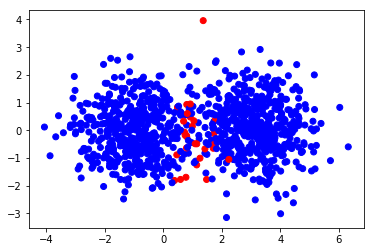

In [24]:
plt.scatter(X_test[:,0], X_test[:,1], c=(predictions!=y_test), cmap='bwr')
print("Accuracy: {:.02f}%".format(100*sum(predictions == y_test)/len(predictions)))

Only a tiny number of errors (hopefully!).  Good work!

## Congratulations

You have implemented a deep neural network using tensorflow!

One remaining API you may want to take a look at is [tf.nn.embedding_lookup](https://www.tensorflow.org/versions/r0.11/api_docs/python/nn.html#embedding_lookup).  It is simply an op that takes a variable (like the "w" you did in your affine layer) and returns a column from it.  This will be useful later when we "embed" words into vector space.  We'll have our embedding table as a single variable with dimensions `[num_words x word_vector_length]` and we'll use this op to select word vectors from it efficiently.